# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

In [3]:
import math
import random
import timeit
import matplotlib.pyplot as plt


Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [4]:
## JARVIS MARCH

def direction(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return 2


def jarvismarch(inputSet):
    '''
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''
    if len(inputSet) < 3:
        return

    minPoint = min(inputSet, key= lambda inputSet: inputSet[0])
    index = inputSet.index(minPoint)

    hullPoints = []
    p = index
    hullPoints.append(minPoint)

    while (True):
        q = (p + 1) % len(inputSet)
        for r in range(len(inputSet)):
            if r == p:
                continue 
            if(direction(inputSet[p], inputSet[r], inputSet[q]) == 2):
                q = r

        p = q
        if p == index:
            break
        hullPoints.append(inputSet[p])

    return hullPoints

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [5]:
## GRAHAM SCAN

def orientation(p1, p2, p3):
    """
    To find the orientation of an ordered triplet (p1, p2, p3).
    The function returns following values:
    0 --> p1, p2 and p3 are collinear
    1 --> Clockwise
    2 --> Counterclockwise
    """
    val = (p2[1] - p1[1]) * (p3[0] - p2[0]) - (p2[0] - p1[0]) * (p3[1] - p2[1])
    if val == 0:
        return 0  # collinear
    elif val > 0:
        return 1  # clockwise
    else:
        return 2  # counter-clockwise


def square_distance(p1, p2):
    """
    Calculate the square of the distance between two points
    """
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2


def bottom_left(points):
    """
    Find the bottom-left point from a list of points.
    """
    return min(points, key=lambda p: (p[1], p[0]))


def graham_scan(points):
    """
    Graham scan algorithm to find the convex hull of a set of points, using tuples.
    """
    # Step 1: Find the bottom-left point and sort the points based on polar angle with respect to it
    start = bottom_left(points)
    sorted_points = sorted(points,
                           key=lambda p: (math.atan2(p[1] - start[1], p[0] - start[0]), square_distance(start, p)))

    # Step 2: Scan the sorted list of points
    hull = [sorted_points[0], sorted_points[1]]  # Initialize the hull with the first two points

    for point in sorted_points[2:]:
        while len(hull) > 1 and orientation(hull[-2], hull[-1], point) != 2:
            hull.pop()  # Remove the last point from the hull if we turn clockwise
        hull.append(point)

    return hull

Use the cell below for all python code needed to realise the **Chan's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [6]:
## CHAN ALGORITHM

def chan(inputSet):
    '''
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''
    #ADD YOUR CODE HERE
    '''
    Steps:
    1. Divide into sections, starting from 3
    2  Apply Jarvis march to each section -> filter sections
    3. Run jarvis march on each section
    ''' 
    def same_point(a,b):
        return a[0] == b[0] and a[1] == b[1]
    
    def distance(a,b):
        return (a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2
    
    # divide the set into sections based on h
    def divide_sections(points, point_in_sec):
        return [points[i:i + point_in_sec] for i in range(0, len(points), point_in_sec)]
    
    # Calculate the angle from current point to last point and checkpoint
    def angle(last_point, current_point, check_point):
        dot_product = (last_point[0] - current_point[0]) * (check_point[0] - current_point[0]) \
            + (last_point[1] - current_point[1]) * (check_point[1] - current_point[1])
        
        length_product = math.sqrt((last_point[0] - current_point[0])**2 + (last_point[1] - current_point[1]) ** 2) * \
            math.sqrt((check_point[0] - current_point[0]) ** 2 + (check_point[1] - current_point[1]) ** 2)
        
        if length_product == 0:
            return -1
        cos_theta = dot_product / length_product
        cos_theta = max(min(cos_theta, 1.0), -1.0)  # clamp to [-1, 1] to avoid domain error
        return math.acos(cos_theta)
   
    # check wether a is above b referencing c
    def above(a,b,l_p, c_p):
        return  angle(l_p, c_p, a) > angle(l_p, c_p, b) 

    def below(a,b,l_p, c_p):
        return  angle(l_p, c_p, a) < angle(l_p, c_p, b) 
    
    def binary_search(last_point, current_point, points):
        """
        Use Binary Search to find the tangent point by detecting:
            1. The angle between last point, current point and new point from input
            2. Set start, end, mid
            3. In each loop, if the vector of pointA to the next point is facing down, 
                and the vector of the point before A towards A is not facing up, then A is the tangent
            4. update start and end based on different facing direction of start and mid points.
        """    
        
        start = 0
        end = len(points) - 1
        # used for infinite loop checking
        record = (-10,-10,-10)
        
        # Only one point from the input, return the point
        if start == end:
            return points[0]
        
        while True:
            mid = (start + end) // 2
            mid_dn = below(points[mid + 1], points[mid], last_point, current_point)
            # raise exception if stuck in the loop
            if record == (start, mid, end):
                raise Exception("Error")
            record = (start, mid, end)
            
            if angle(last_point, current_point, points[start+1]) == angle(last_point, current_point, points[start]):
                return points[start+1]
            
            # check if mid is the target tangent point
            if mid_dn and (not above (points[mid - 1], points[mid], last_point, current_point)):
                return points[mid]

            # check if start is the target tangent point
            elif below(points[start+1], points[start], last_point, current_point) \
                and (not above (points[start-1], points[start], last_point, current_point)):
                return points[start]
            
            # check if end is the target tangent point
            elif below(points[end+1 - len(points)], points[end], last_point, current_point)\
                and (not above (points[end - 1], points[end], last_point, current_point)):
                return points[end]
            
            else:
                start_up = above(points[start + 1], points[start], last_point, current_point)
                # start point facing up
                if start_up:
                    # mid point facing down
                    if mid_dn:
                        end = mid
                    else:
                        # start point is above mid
                        if above(points[start], points[mid], last_point, current_point):
                            end = mid
                        # start point below mid
                        else:
                            start = mid
                # start point facing down
                else:
                    # mid point not facing down
                    if not mid_dn:
                        start = mid
                    else:
                        # start point above mid
                        if below(points[start], points[mid],last_point,current_point):
                            end = mid
                        # start point below mid
                        else:
                            start = mid
                        
    # Find the next
    def find_next_global_convex_hull(recorded_ch, divided_sections):
        current_point = recorded_ch[-1]
        last_point = recorded_ch[-2]
        most_right_angle = 0
        most_right_point = last_point
        
        for section in divided_sections:
            section_tangent_point = binary_search(last_point, current_point, section)
            section_tangent_angle = angle(last_point, current_point, section_tangent_point)
            if section_tangent_angle > most_right_angle:
                most_right_angle = section_tangent_angle
                most_right_point = section_tangent_point
            
            elif section_tangent_angle == most_right_angle:
                # Make sure the search returns only the endpoints not the point sit on the line
                if distance(current_point, section_tangent_point) > distance(current_point, most_right_point):
                    most_right_angle = section_tangent_angle
                    most_right_point = section_tangent_point 

        return most_right_point
    
    n = len(inputSet)
    init_h = 2
    left_most_point = min(inputSet, key=lambda point: point[0])
    # This will be the point one unit above the startpoint, to support it finds the next convex hull
    # It will be recorded in the convexhull list with idx 0
    origin_point = (left_most_point[0],left_most_point[1] + 1)
    
    # check the time of loops is within the limit 
    in_h_times = False
    times = 1
    while not in_h_times:
        divided_section = divide_sections(inputSet, init_h)

        # Find Local Convex Hull
        # divided_section = list(map(lambda section: convex_hull(section), divided_section)) 
        divided_section = list(map(graham_scan, divided_section))
    
        global_convex = [origin_point, left_most_point]

        # find global convex hulls
        for i in range(init_h+1):
            global_convex.append(find_next_global_convex_hull(global_convex, divided_section))
            if (same_point(global_convex[-1], global_convex[1]) and not len(global_convex) == 2):
                in_h_times = True 
                break
        # update limit h (and section number)         
        
        times += 1
        init_h = min(2 ** (2 ** times), n) 
    
     # Extract the origin support point from the result list
    global_convex = global_convex[1:]



## LINEAR CHAN

def linear(points):
    def divide_points(points, h):
        return [points[i:i + h] for i in range(0, len(points), h)]

    n = len(points)
    incomplete_convex = True
    times = 2
    while incomplete_convex :
        h = 2 ** (2 ** times)
        divided_section = divide_points(points, h)
        filtered_points = []
        for section in divided_section:
            filtered_points.extend(graham_scan(section))
        incomplete_convex, result = jarvismarch(filtered_points, h)
        times += 1
    

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [7]:

class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    n: number of points in total  
    h: number of vertices of the convex hull

    Methods
    -------
    
    generateConvexPolygon(): Creates a convex hull  
    generatePointsInside(): Populates the convex polygon with points inside

    """

        
    def __init__(self, n, h):
        self.n = n
        self.h = h
        self.scale = 32767
        self.convexHull = self.generateConvexPolygon()
        self.points = self.generatePointsInside()


    def generatePointsInside(self):
        count = self.h
        points = self.convexHull.copy()

        while count < self.n:
            xPoint = random.randint(0, self.scale)
            yPoint = random.randint(0, self.scale)

            if self.isInsidePoly(xPoint, yPoint):
                points.append((xPoint, yPoint))
                count += 1

        return points

    def isInsidePoly(self, xPoint, yPoint):
        inside = False

        p1x, p1y = self.convexHull[0]
        for i in range(self.h + 1):
            p2x, p2y = self.convexHull[i % self.h]
            if yPoint > min(p1y, p2y) and yPoint <= max(p1y, p2y):
                if xPoint <= max(p1x, p2x):
                    if p1y != p2y:
                        xintersection = (yPoint - p1y) * (p2x - p1x) / (p2y - p1y) + p1x #Ray tracing formula
                    if p1x == p2x or xPoint <= xintersection:
                        inside = not inside
        
            p1x, p1y = p2x, p2y

        return inside 


    def generateConvexPolygon(self):
        # Credit to Pavel Valtr for convex polygon algorithm design

        ''' 
        Starting from a convex polygon allows specfying h value.
        Valtr's algorithm allows random polygons in a square domain unlike circumcircle method. 
        '''

        xs = []
        ys = []
        for _ in range(self.h):
            xs.append(random.randint(0, self.scale))
            ys.append(random.randint(0, self.scale))
            
        xs.sort()
        ys.sort()
        min_x, *xs, max_x = xs
        min_y, *ys, max_y = ys
        
        xVector = self.makeVectors(xs, min_x, max_x)
        yVector = self.makeVectors(ys, min_y, max_y)
        random.shuffle(yVector)

        vectors = sorted(zip(xVector, yVector), key=self.vectorAngle)
        xPoint = yPoint = 0
        poly_x_min = poly_y_min = 0 
        points = []

        for xVector, yVector in vectors:
            points.append((xPoint, yPoint))

            xPoint += xVector
            yPoint += yVector
            
            poly_x_min = min(poly_x_min, xPoint)
            poly_y_min = min(poly_y_min, yPoint)

        xShift, yShift = min_x - poly_x_min, min_y - poly_y_min
        points = [(xPoint + xShift, yPoint + yShift) for xPoint, yPoint in points]

        return points
            

    
    def makeVectors(self, coordinates, min_coord, max_coord):
        '''
        Creates a random set of vectors that cancel each other out within range: min_coord, max_coord
        '''
        vectors = []
        last_down = last_up = min_coord

        for coord in coordinates:
            if random.getrandbits(1): #randomiser function
                vectors.append(coord - last_down)
                last_down = coord
            else:
                vectors.append(last_up - coord)
                last_up = coord
        vectors.extend((max_coord - last_down, last_up - max_coord))

        return vectors

    def vectorAngle(self, vector):
        x, y = vector
        return math.atan2(y, x)
        
        

Use the cell below to implement the requested **experimental framework** API.

In [24]:

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__(self, algorithms, max_n=20000, max_h=20000, interval=500):
        self.algorithms = algorithms
        self.max_n = max_n
        self.max_h = max_h
        self.interval = interval


    def run(self):
        results = {}

        for n in range(100, self.max_n + 1, self.interval):
            data = TestDataGenerator(n, 100).points
            for algorithm in self.algorithms:
                time = timeit.timeit(lambda: algorithm(data), number=1)
            
                if algorithm.__name__ not in results:
                    results[algorithm.__name__] = {}
                results[algorithm.__name__][('n', n)] = time

        for h in range(100, self.max_h + 1, self.interval):
            data = TestDataGenerator(100, h).points
            for algorithm in self.algorithms:
                time = timeit.timeit(lambda: algorithm(data), number=1)
            
                if algorithm.__name__ not in results:
                    results[algorithm.__name__] = {}
                results[algorithm.__name__][('h', h)] = time
            
        return results
    

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

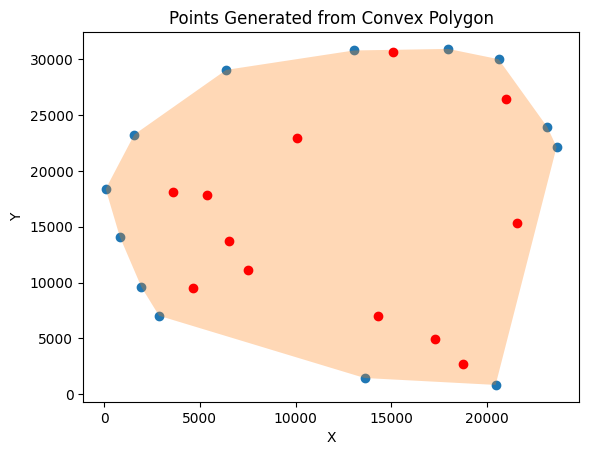

In [9]:
## PLOT DATA GENERATION

import matplotlib.pyplot as plt

data_generator = TestDataGenerator(25, 13)
points = data_generator.convexHull

x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
plt.scatter(x_coords, y_coords)
plt.fill(x_coords, y_coords, alpha=0.3)

# Plot the additional points in a separate color
additional_points = data_generator.points
additional_x_coords = [point[0] for point in additional_points[data_generator.h:]]
additional_y_coords = [point[1] for point in additional_points[data_generator.h:]]
plt.scatter(additional_x_coords, additional_y_coords, color='red')

# Set plot title and labels
plt.title("Points Generated from Convex Polygon")
plt.xlabel("X")
plt.ylabel("Y")

# Show the plot
plt.show()

In [25]:
# ADD YOUR TEST CODE HERE 

framework = ExperimentalFramework([jarvismarch, graham_scan, chan], 2000, 2000, 100)

results = framework.run()

#

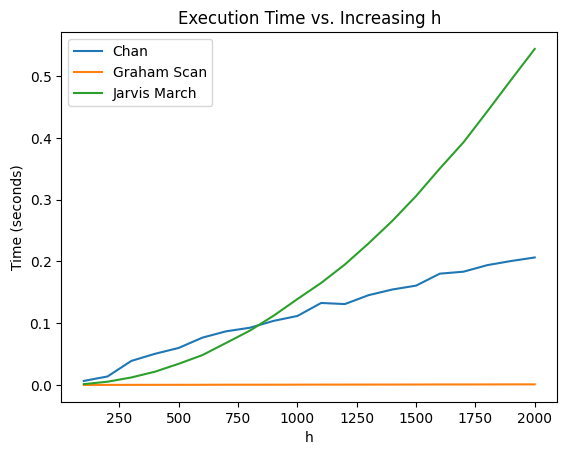

In [29]:
## INCREASING H

h_values = sorted(set(h for algorithm in results for (var, h) in results[algorithm] if var == 'h'))

chan_values = [results['chan'][('h', h)] for h in h_values]
graham_scan_values = [results['graham_scan'][('h', h)] for h in h_values]
jarvismarch_values = [results['jarvismarch'][('h', h)] for h in h_values]

plt.plot(h_values, chan_values, label='Chan')
plt.plot(h_values, graham_scan_values, label='Graham Scan')
plt.plot(h_values, jarvismarch_values, label='Jarvis March')

plt.title('Execution Time vs. Increasing h')
plt.xlabel('h')
plt.ylabel('Time (seconds)')

plt.legend()
plt.show()


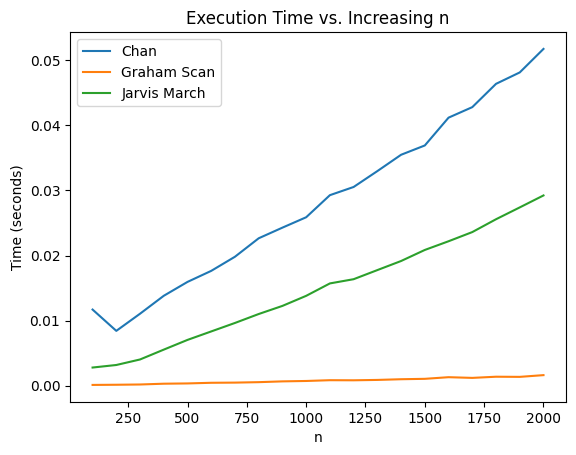

In [28]:
## INCREASING N

n_values = sorted(set(n for algorithm in results for (var, n) in results[algorithm] if var == 'n'))

chan_values = [results['chan'].get(('n', n), None) for n in n_values]
graham_scan_values = [results['graham_scan'].get(('n', n), None) for n in n_values]
jarvismarch_values = [results['jarvismarch'].get(('n', n), None) for n in n_values]


plt.plot(n_values, chan_values, label='Chan')
plt.plot(n_values, graham_scan_values, label='Graham Scan')
plt.plot(n_values, jarvismarch_values, label='Jarvis March')

plt.title('Execution Time vs. Increasing n')
plt.xlabel('n')
plt.ylabel('Time (seconds)')

plt.legend()
plt.show()